# Electricity Consumption Prediction using Deep LSTM

Importing necessary libraries

In [1]:
#!pip install workalendar

In [2]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from matplotlib import rcParams  # Used to set default paremeters

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from workalendar.europe import UnitedKingdom

# Default Parameters

In order to save time and avoid having to set the parameters for each plot, I will define the default font and font sizes for all the plots.

In [3]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Loading Data

Used the UK historic electricity demand between 2009 and 2022.

In [4]:
df = pd.read_csv("historic_demand_2009_2023.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()
df

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253481,2023-06-17,44,23881,26248,21841,648,6538,0,14285,0,6,1363,385,-699,-453,-356,-353,1298.0,430.0,0
253482,2023-06-17,45,23675,25818,21674,667,6538,0,14285,0,6,1447,401,-520,-453,-405,-259,1298.0,163.0,0
253483,2023-06-17,46,23064,25174,21093,685,6538,0,14285,0,5,1437,400,-499,-453,-401,-252,1298.0,139.0,0
253484,2023-06-17,47,21947,23659,20086,692,6538,0,14285,0,5,476,227,-194,-399,-335,-279,1298.0,160.0,0


# Data understanding

The dataset includes a description of all the columns, but for this project I will only use three columns:

SETTLEMET_DATA: date in format dd/mm/yyyy

SETTLEMENT_PERIOD: half hourly period for the historic outtunr occurred

TSD (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

TSD is target variable and the aim is to predict the future demand using different models.

In [5]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
82782,2013-09-20,8,24106,26091,21757,541,2337,0,2985,0,1225,1415,0,927,0,-260,0,NaN,NaN,0
47701,2011-09-19,48,26276,27683,23557,738,1836,0,668,0,763,494,0,-144,0,0,0,NaN,NaN,0
43333,2011-06-21,31,38533,39455,34725,909,1822,60,365,0,9,0,0,-1,-412,0,0,NaN,NaN,0
41150,2011-05-07,7,23262,25214,20895,535,1786,0,161,0,1166,966,0,102,-286,0,0,NaN,NaN,0
107275,2015-02-13,40,45192,46448,41145,1067,4087,0,7128,0,9,1994,0,1007,-202,-445,0,NaN,NaN,0
11718,2009-08-31,42,34854,35968,31301,725,1755,0,0,93,13,-307,0,0,-387,0,0,NaN,NaN,1
109912,2015-04-09,43,37119,38201,33749,450,3989,0,8482,0,11,1998,0,987,-144,-427,0,NaN,NaN,0


In [6]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
count,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,253486.000000,78190.000000,78190.000000,253486.000000
mean,24.500039,31738.576900,33125.989392,28870.928734,1210.536183,4233.498962,812.728798,7811.347562,7.330914,318.299551,922.835198,17.917487,540.808262,-110.122188,-27.601067,153.295511,213.498593,-29.672925,0.023102
std,13.853713,7789.703027,7718.453371,7064.231493,922.609925,1929.510637,1620.870939,5485.267750,41.032891,542.455343,1089.575795,314.609851,508.750321,224.069803,251.914834,390.045471,511.623257,385.799859,0.150227
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000,0.000000
25%,12.250000,25508.000000,27121.000000,23194.000000,523.000000,2085.000000,0.000000,1833.000000,0.000000,8.000000,221.000000,0.000000,0.000000,-252.000000,-136.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,31161.000000,32361.000000,28328.000000,971.000000,4210.000000,0.000000,9300.000000,0.000000,12.000000,1247.000000,0.000000,763.000000,-124.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,37467.000000,38620.000000,34112.000000,1643.000000,6231.000000,755.000000,13080.000000,0.000000,446.000000,1899.000000,0.000000,994.000000,43.000000,2.000000,0.000000,666.000000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5354.000000,6574.000000,9830.000000,14285.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,1.000000


In [7]:
df.shape

(253486, 20)

Let's sort the values by date as some of them have been misplaced in the original dataset

In [8]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)
df

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253481,2023-06-17,44,23881,26248,21841,648,6538,0,14285,0,6,1363,385,-699,-453,-356,-353,1298.0,430.0,0
253482,2023-06-17,45,23675,25818,21674,667,6538,0,14285,0,6,1447,401,-520,-453,-405,-259,1298.0,163.0,0
253483,2023-06-17,46,23064,25174,21093,685,6538,0,14285,0,5,1437,400,-499,-453,-401,-252,1298.0,139.0,0
253484,2023-06-17,47,21947,23659,20086,692,6538,0,14285,0,5,476,227,-194,-399,-335,-279,1298.0,160.0,0


# Data preparation

The goal of this section is to prepare the data for the model. To do so, I will perform the following actions:

- Find out how many nan values there are and drop the columns containing nan values
- Drop rows whose settlement_period exceeds 48, as the API states that 48 is the maximum number of samples per day
- Remove outliers

As a bonus, I will add a new feature at this point, bank holidays in the UK. The reason to add them at this point is that I will transform the date format for better analysis in a future section. Therefore, it's easier for me to add the bank holidays while performing data preparation.

Let's begin checking if there arenan values:

In [9]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
dtype: bool

As can be seen, only two columns include nan values. Let's check how many nan values there are in each column

In [10]:
pd.concat(
    [
    df["nsl_flow"].isna().value_counts().to_frame(),
    df["eleclink_flow"].isna().value_counts().to_frame()],
    axis=1)

,nsl_flow,eleclink_flow
True,175296,175296
False,78190,78190


It seems that both features have the same number of nan values. Let's have a look at that the dataframe containing the nan value:

In [11]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,13,1960,0,777,-454,-535,0,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,23,1182,0,-268,-455,-536,0,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,36,1157,0,-297,-455,-536,0,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,49,1546,0,-467,-454,-466,0,NaN,NaN,0


It seems that neither feature existed from 2009 to 2018. The best thing is to drop these features.

Also, I will remove the rows where the settlement_period exceeds 48, as the maximum number is 48. Any values larger than 48 is a fault when logging the data.

In [12]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1,inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
df

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253453,2023-06-17,44,23881,26248,21841,648,6538,0,14285,0,6,1363,385,-699,-453,-356,-353,0
253454,2023-06-17,45,23675,25818,21674,667,6538,0,14285,0,6,1447,401,-520,-453,-405,-259,0
253455,2023-06-17,46,23064,25174,21093,685,6538,0,14285,0,5,1437,400,-499,-453,-401,-252,0
253456,2023-06-17,47,21947,23659,20086,692,6538,0,14285,0,5,476,227,-194,-399,-335,-279,0


# Bank holidays

Bank holidays are very important in time series forecasting as they often affect the data values on those days. Therefore, I want to add a new column to my dataset to state whether each day was bank holiday or not.

Using Python Holidays API I managed to make work for my usecase.

Since the dataset covers electricity demand for England and Wales, the first step is to check that the two countries have the same bank holidays:

In [14]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

pd.DataFrame([bank_holiday_england])

True


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,"(2016-01-01, New Year's Day)","(2016-12-25, Christmas Day)","(2016-12-27, Christmas Day (Observed))","(2016-12-26, Boxing Day)","(2016-03-25, Good Friday)","(2016-05-02, May Day)","(2016-05-30, Spring Bank Holiday)","(2016-03-28, Easter Monday)","(2016-08-29, Late Summer Bank Holiday)","(2017-01-01, New Year's Day)",...,"(2014-08-25, Late Summer Bank Holiday)","(2015-01-01, New Year's Day)","(2015-12-25, Christmas Day)","(2015-12-26, Boxing Day)","(2015-12-28, Boxing Day (Observed))","(2015-04-03, Good Friday)","(2015-05-04, May Day)","(2015-05-25, Spring Bank Holiday)","(2015-04-06, Easter Monday)","(2015-08-31, Late Summer Bank Holiday)"


Having seen that the bank holidays are the same, I can proceed with this python package to extract the bank holidays and store them in the right format.

It's worth noting that this package includes the original bank holiday and when it was observed. I will only store the observed days.

In [15]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

Once I've verified that the holidays are correctly loaded, one can compare the holiday_dates variable and the date in the dataset and store the boolean output in a new column:

In [16]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
245180,2022-12-27,25,28923,29873,26177,2902,6545,1130,13861,0,6,1005,991,1004,-302,-42,999,1
210063,2020-12-25,40,29341,29953,27613,1942,6527,0,13080,0,11,1805,-1,0,334,504,902,1
235215,2022-06-02,44,24996,29392,22589,539,6545,0,13859,0,8,-850,-1028,-200,-215,0,-700,1
227699,2021-12-28,14,23265,24237,20901,1715,6527,0,13080,0,372,1007,991,1051,151,60,999,1
210361,2021-01-01,2,28501,29114,26281,1026,6527,0,13080,0,12,2004,-1,0,359,203,999,1
109715,2015-04-06,2,24696,26063,22183,241,3989,0,8475,0,653,1919,0,962,-104,-110,0,1
192515,2019-12-26,10,19740,22439,17987,2326,6465,0,13080,0,1542,1405,0,-557,81,504,414,1


The sample dataframe above is ok to make sure that the new column has been created, but one can inspect the bank holidays more easily using a plot.

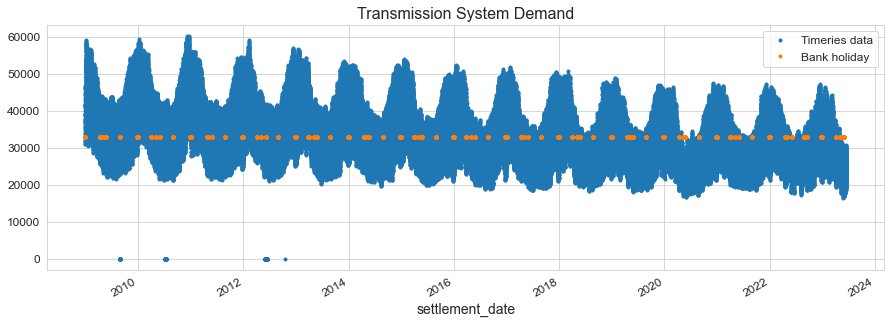

In [17]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Transmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. However, this plot also shows the presence of data points equal to 0. These values will be removed in the next section.

Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, let's create a new plot focusing on a single week:

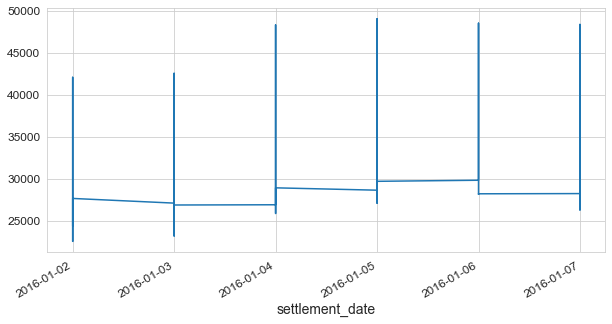

In [18]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

This plot isn't what I was expecting... Am I plotting the right parameter or is there something wrong in the dataset? One can begin by inspecting the dataframe:

The plot wasn't wrong! In the process of seeting the date as the index I haven't added the hour. Therefore, the 48 samples per day are overlayed on top of each other.

Before going forward I need to do two things:

Remove outliers
Add the hour to the date and set it as the index

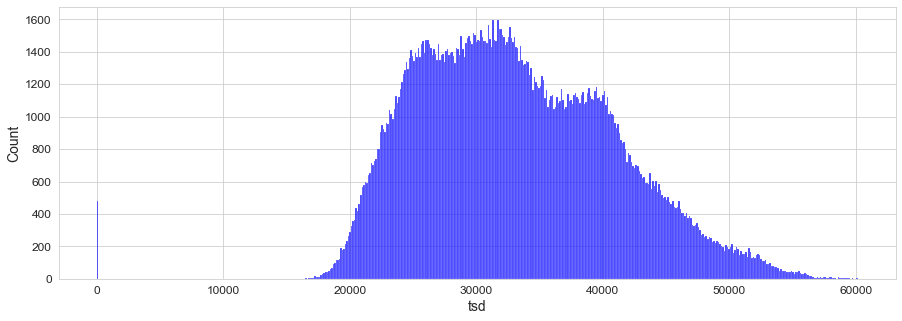

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In the plot above, one can see that there are multiple 0 values. A histogram will show how many samples are actually equal to 0.

I will not only delete the values equal to 0 but the entire day where there are values equal to 0. The reason being that otherwise the remaining daily values would not be representative of the entire day

In [20]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days

['2009-08-29',
 '2009-08-30',
 '2010-07-09',
 '2010-07-10',
 '2010-07-13',
 '2010-07-14',
 '2012-05-29',
 '2012-05-30',
 '2012-05-31',
 '2012-06-01',
 '2012-06-02',
 '2012-06-03',
 '2012-06-04',
 '2012-06-11',
 '2012-10-14']

In [21]:
null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.to_list())
    
null_days_index

[[11518,
  11519,
  11520,
  11521,
  11522,
  11523,
  11524,
  11525,
  11526,
  11527,
  11528,
  11529,
  11530,
  11531,
  11532,
  11533,
  11534,
  11535,
  11536,
  11537,
  11538,
  11539,
  11540,
  11541,
  11542,
  11543,
  11544,
  11545,
  11546,
  11547,
  11548,
  11549,
  11550,
  11551,
  11552,
  11553,
  11554,
  11555,
  11556,
  11557,
  11558,
  11559,
  11560,
  11561,
  11562,
  11563,
  11564,
  11565],
 [11566,
  11567,
  11568,
  11569,
  11570,
  11571,
  11572,
  11573,
  11574,
  11575,
  11576,
  11577,
  11578,
  11579,
  11580,
  11581,
  11582,
  11583,
  11584,
  11585,
  11586,
  11587,
  11588,
  11589,
  11590,
  11591,
  11592,
  11593,
  11594,
  11595,
  11596,
  11597,
  11598,
  11599,
  11600,
  11601,
  11602,
  11603,
  11604,
  11605,
  11606,
  11607,
  11608,
  11609,
  11610,
  11611,
  11612,
  11613],
 [26588,
  26589,
  26590,
  26591,
  26592,
  26593,
  26594,
  26595,
  26596,
  26597,
  26598,
  26599,
  26600,
  26601,
  26602,

In [22]:
null_days_index = [item for sublist in null_days_index for item in sublist]
null_days_index

[11518,
 11519,
 11520,
 11521,
 11522,
 11523,
 11524,
 11525,
 11526,
 11527,
 11528,
 11529,
 11530,
 11531,
 11532,
 11533,
 11534,
 11535,
 11536,
 11537,
 11538,
 11539,
 11540,
 11541,
 11542,
 11543,
 11544,
 11545,
 11546,
 11547,
 11548,
 11549,
 11550,
 11551,
 11552,
 11553,
 11554,
 11555,
 11556,
 11557,
 11558,
 11559,
 11560,
 11561,
 11562,
 11563,
 11564,
 11565,
 11566,
 11567,
 11568,
 11569,
 11570,
 11571,
 11572,
 11573,
 11574,
 11575,
 11576,
 11577,
 11578,
 11579,
 11580,
 11581,
 11582,
 11583,
 11584,
 11585,
 11586,
 11587,
 11588,
 11589,
 11590,
 11591,
 11592,
 11593,
 11594,
 11595,
 11596,
 11597,
 11598,
 11599,
 11600,
 11601,
 11602,
 11603,
 11604,
 11605,
 11606,
 11607,
 11608,
 11609,
 11610,
 11611,
 11612,
 11613,
 26588,
 26589,
 26590,
 26591,
 26592,
 26593,
 26594,
 26595,
 26596,
 26597,
 26598,
 26599,
 26600,
 26601,
 26602,
 26603,
 26604,
 26605,
 26606,
 26607,
 26608,
 26609,
 26610,
 26611,
 26612,
 26613,
 26614,
 26615,
 26616,


In [23]:
df.drop(index=null_days_index, inplace=True)

In [24]:
df.reset_index(drop=True, inplace=True)
df

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252733,2023-06-17,44,23881,26248,21841,648,6538,0,14285,0,6,1363,385,-699,-453,-356,-353,0
252734,2023-06-17,45,23675,25818,21674,667,6538,0,14285,0,6,1447,401,-520,-453,-405,-259,0
252735,2023-06-17,46,23064,25174,21093,685,6538,0,14285,0,5,1437,400,-499,-453,-401,-252,0
252736,2023-06-17,47,21947,23659,20086,692,6538,0,14285,0,5,476,227,-194,-399,-335,-279,0


# Feature creation

The first step in the feature creation is to change the date format to include the hourly values. The settlement_period values refer to how many samples have been taken per day. Given that there are 48 samples per day, each sample represents 30 minutes of the day.

In [25]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.head(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


As can be seen, a new column called period_hour includes the hour at which the electricity demand measurement was taken. One can now combine it with the actual date as follows:

In [26]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
129665,2016-06-09 16:30:00,34,16:30:00,32983,33901,29749,334,4260,3990,10500,0,5,1996,0,999,0,-413,0,0
35374,2011-01-14 01:00:00,3,1:00:00,33378,35661,29910,1267,1730,0,85,0,1251,1992,0,0,-432,0,0,0
175905,2019-01-29 02:30:00,6,2:30:00,28585,31454,25977,1418,5918,0,13052,0,1600,1495,0,1058,-424,-245,0,0
72917,2013-03-15 06:30:00,14,6:30:00,37258,39387,34086,1022,2113,5,2553,0,505,-916,0,196,-108,0,0,0
194197,2020-02-14 05:30:00,12,5:30:00,27418,29674,25627,2173,6465,0,13080,0,159,1578,0,-616,81,504,-881,0


The settlement_date column is now in the right format to use an index:

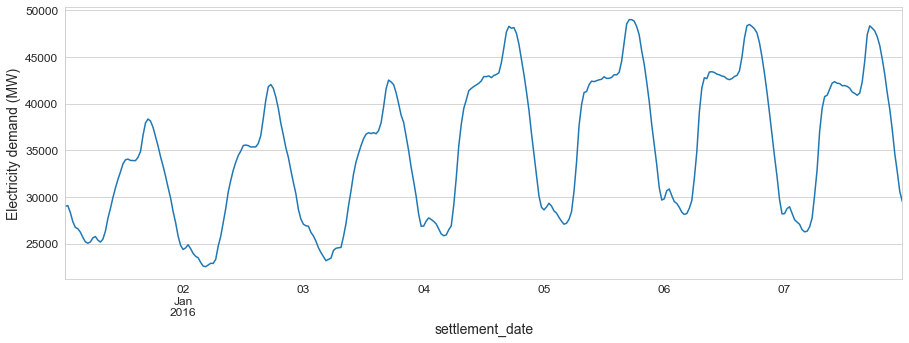

In [27]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

The new features consists of different bits of information "already stored" in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions.

In [28]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

In [29]:
df = create_features(df)
df

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,east_west_flow,nemo_flow,is_holiday,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,...,0,0,1,1,3,1,1,1,2009,1
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,...,0,0,1,1,3,1,1,1,2009,1
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,...,0,0,1,1,3,1,1,1,2009,1
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,...,0,0,1,1,3,1,1,1,2009,1
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,...,0,0,1,1,3,1,1,1,2009,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-17 21:30:00,44,21:30:00,23881,26248,21841,648,6538,0,14285,0,...,-356,-353,0,17,5,168,2,6,2023,24
2023-06-17 22:00:00,45,22:00:00,23675,25818,21674,667,6538,0,14285,0,...,-405,-259,0,17,5,168,2,6,2023,24
2023-06-17 22:30:00,46,22:30:00,23064,25174,21093,685,6538,0,14285,0,...,-401,-252,0,17,5,168,2,6,2023,24


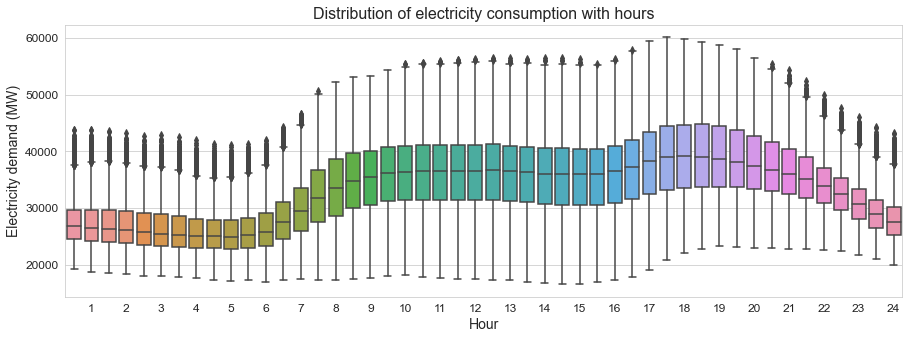

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

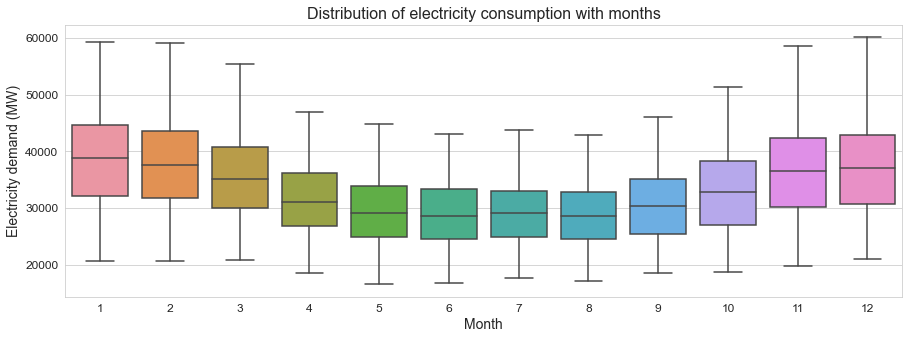

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

It seems that the lowest consumption occurs during the summer months.

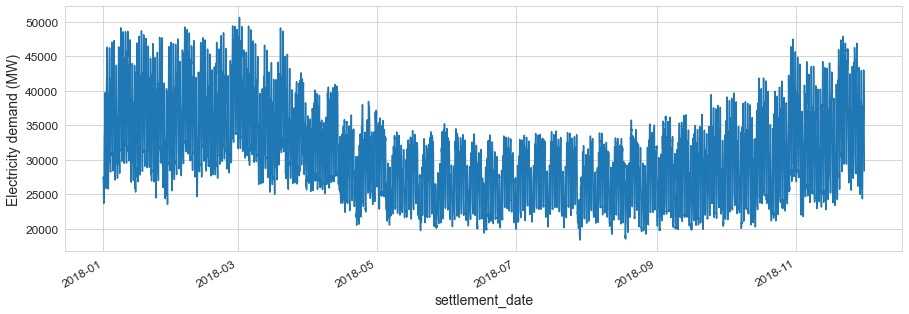

In [32]:
df.loc[(df.index > "01-01-2018") & (df.index < "12-01-2018")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

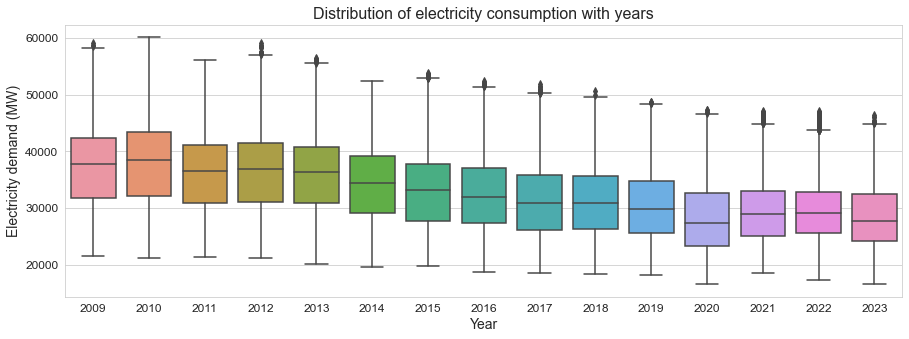

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption.

# Train-Test-Validate Split

In [35]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

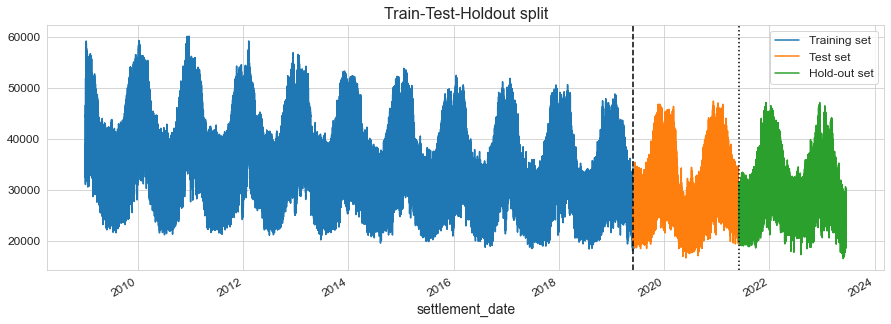

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Train-Test-Holdout split")
plt.legend();

In [39]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

In [40]:
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]
hold_out_data_keras = hold_out_data[FEATURES_TARGET]

In [41]:
train_data_keras.shape

(181802, 10)

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)
hold_out_data_keras_s = scaler.transform(hold_out_data_keras.values)

In [43]:
train_data_keras_s

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.48986535],
       [1.        , 0.0212766 , 0.        , ..., 0.        , 0.        ,
        0.49605082],
       [1.        , 0.04255319, 0.        , ..., 0.        , 0.        ,
        0.48860446],
       ...,
       [0.        , 0.95744681, 1.        , ..., 1.        , 0.40384615,
        0.18363706],
       [0.        , 0.9787234 , 1.        , ..., 1.        , 0.40384615,
        0.15173431],
       [0.        , 1.        , 1.        , ..., 1.        , 0.40384615,
        0.12052148]])

In [44]:
X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)

In [45]:
X_train_keras.shape

(181802, 1, 9)

In [46]:
y_train_keras = train_data_keras_s[:,-1]

y_train_keras

array([0.48986535, 0.49605082, 0.48860446, ..., 0.18363706, 0.15173431,
       0.12052148])

In [47]:
X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [48]:
X_hold_out_keras = (
    hold_out_data_keras_s[:,:-1].
    reshape(hold_out_data_keras_s.shape[0],1,len(FEATURES))
)
y_hold_out_keras = hold_out_data_keras_s[:,-1]

In [49]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

In [50]:
# Define callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')

reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='min'
)


In [51]:
# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=10,
    batch_size=155,
    validation_data=(X_hold_out_keras, y_hold_out_keras),
    callbacks=[early_stopping, reduce_lr_loss]
)

Epoch 1/10
1173/1173 [==============================] - 18s 12ms/step - loss: 0.1370 - val_loss: 0.0833 - lr: 0.0010
Epoch 2/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0953 - val_loss: 0.0759 - lr: 0.0010
Epoch 3/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0871 - val_loss: 0.0690 - lr: 0.0010
Epoch 4/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0792 - val_loss: 0.0617 - lr: 0.0010
Epoch 5/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0747 - val_loss: 0.0609 - lr: 0.0010
Epoch 6/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0727 - val_loss: 0.0604 - lr: 0.0010
Epoch 7/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0713 - val_loss: 0.0636 - lr: 0.0010
Epoch 8/10
1173/1173 [==============================] - 14s 12ms/step - loss: 0.0704 - val_loss: 0.0681 - lr: 0.0010
Epoch 9/10
1173/1173 [==============================] - 15s 12ms

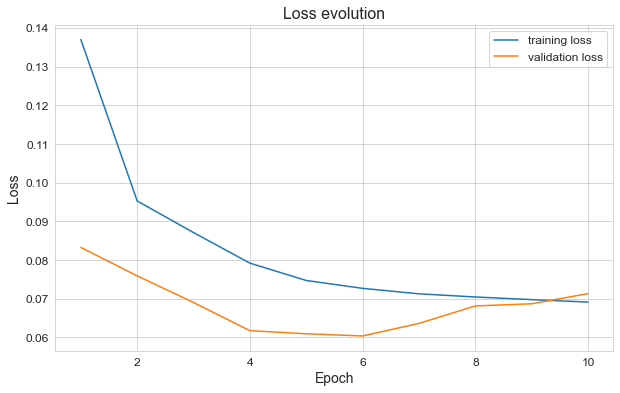

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

Once the neiureal network has been trained, we can make predictions on the test set. Remember that we had to scale all the data to fit the mode. thus, we first need to inverse transform the output before we can use for plotting or to calculate the performance with respect to the original electricity demand values.

In [53]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)


1097/1097 [==============================] - 3s 2ms/step


In [54]:
y_test = test_data[TARGET]
result_frame=y_test.to_frame()

In [55]:
result_frame["pred_lstm"] = results_lstm[:,-1]

In [56]:
result_frame

,tsd,pred_lstm
settlement_date,,
2019-06-01 00:00:00,22025,21906.511517
2019-06-01 00:30:00,21501,21706.291999
2019-06-01 01:00:00,21332,21494.637737
2019-06-01 01:30:00,21405,21270.758271
2019-06-01 02:00:00,21195,21035.253647
...,...,...
2021-05-31 21:30:00,27106,25187.473270
2021-05-31 22:00:00,26350,24447.900988
2021-05-31 22:30:00,25161,24023.760664


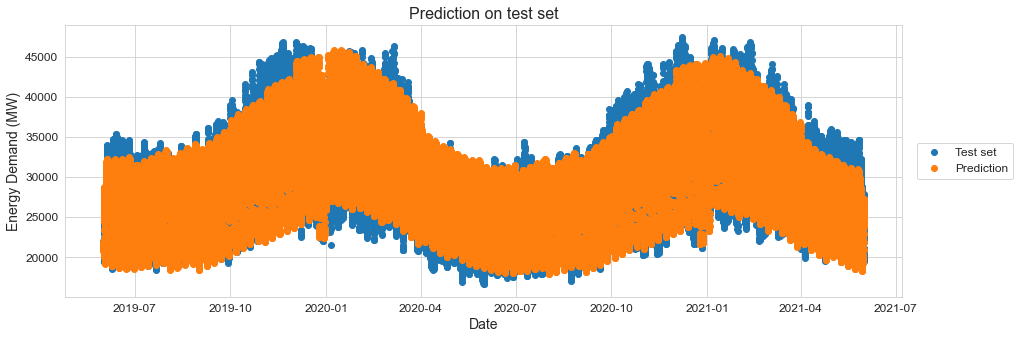

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

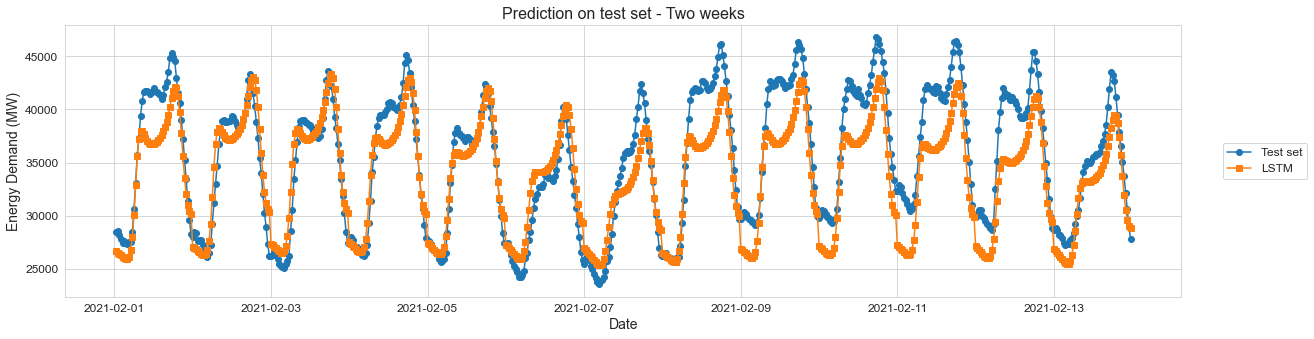

In [58]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

It seems like the shape of the daily pattern is almost perfect, although the amplitude isn't correct.

In [61]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))


print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Root Mean Squared Error of the LSTM model is: 2675.17 MW


In [65]:
def mean_absolute_percentage_error(y_true, y_pred):

    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)

    # Calculate MAPE
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

mape = mean_absolute_percentage_error(y_test, result_frame["pred_lstm"])

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape
)

Mean Absolute Percentage Error of the LSTM model is: 7.29
